In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
dataset = load_dataset("Falah/Alzheimer_MRI")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-c08a401c53fe53(…):   0%|          | 0.00/22.6M [00:00<?, ?B/s]

data/test-00000-of-00001-44110b9df98c558(…):   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5120
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
})

In [4]:
label_names = {
    0: "MildDemented",
    1: "ModerateDemented",
    2: "NonDemented",
    3: "VeryMildDemented"
}

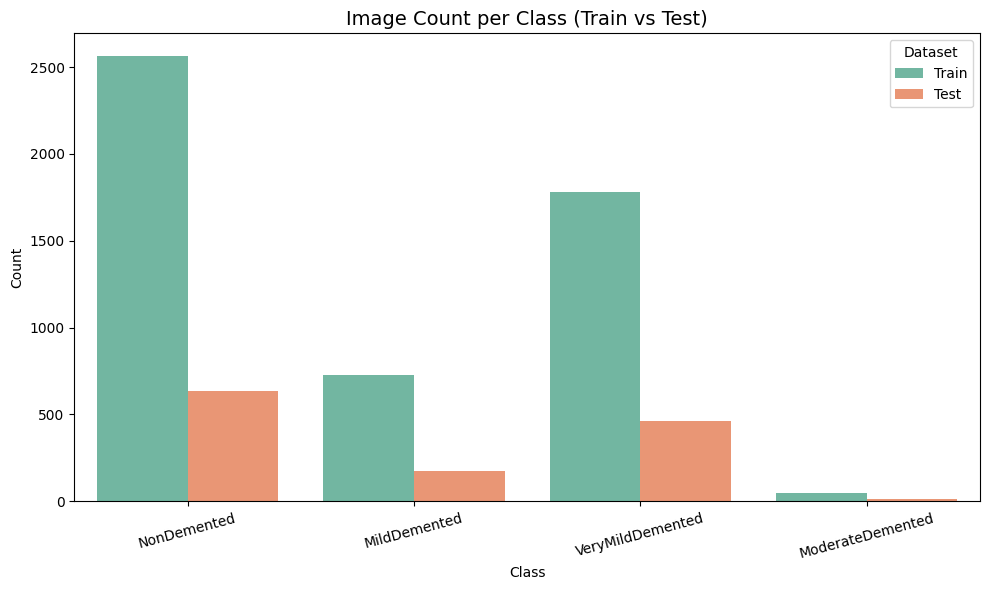

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

train_counts = Counter(dataset['train']['label'])
test_counts = Counter(dataset['test']['label'])


df_train = pd.DataFrame({'Class': [label_names[i] for i in train_counts.keys()],
                         'Count': train_counts.values(),
                         'Dataset': 'Train'})

df_test = pd.DataFrame({'Class': [label_names[i] for i in test_counts.keys()],
                        'Count': test_counts.values(),
                        'Dataset': 'Test'})

df_all = pd.concat([df_train, df_test])

plt.figure(figsize=(10,6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df_all, palette='Set2')
plt.title("Image Count per Class (Train vs Test)", fontsize=14)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

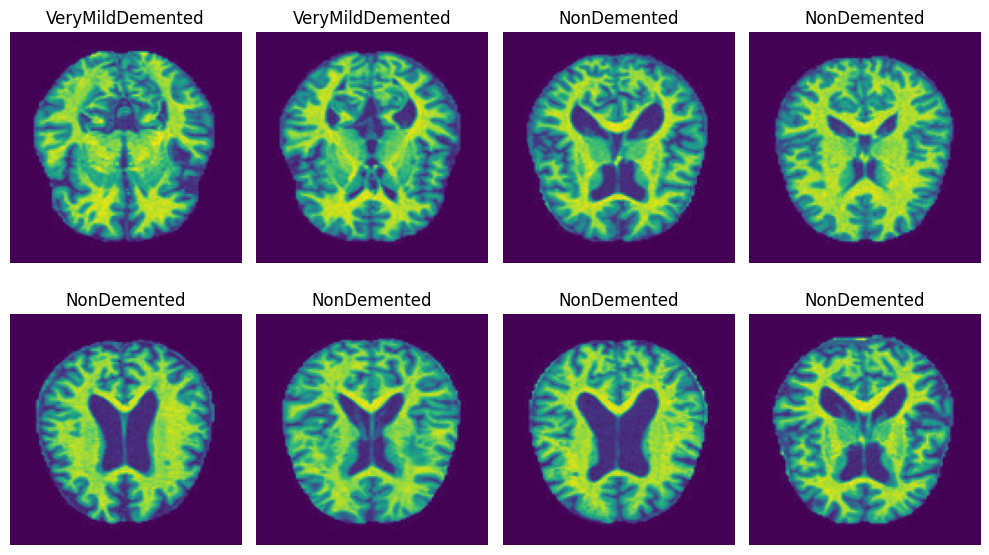

In [6]:
import random

plt.figure(figsize=(10,6))
for i in range(8):
    sample = random.choice(dataset['train'])
    img = sample['image']
    label = label_names[sample['label']]
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
train_valid_split = dataset['train'].train_test_split(test_size=0.10, seed=42)
train_hf = train_valid_split['train']
val_hf   = train_valid_split['test']
test_hf  = dataset['test']

print("HF sizes -> train:", len(train_hf), "val:", len(val_hf), "test:", len(test_hf))

print("Train counts:", Counter(train_hf['label']))
print("Val counts:  ", Counter(val_hf['label']))
print("Test counts: ", Counter(test_hf['label']))

HF sizes -> train: 4608 val: 512 test: 1280
Train counts: Counter({2: 2313, 3: 1612, 0: 644, 1: 39})
Val counts:   Counter({2: 253, 3: 169, 0: 80, 1: 10})
Test counts:  Counter({2: 634, 3: 459, 0: 172, 1: 15})


In [17]:
from torch.utils.data import Dataset

class HFDatasetTorch(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item['image']

        if hasattr(img, "mode"):
            if img.mode != "RGB":
                img = img.convert("RGB")
        else:

            from PIL import Image
            img = Image.fromarray(img).convert("RGB")

        label = int(item['label'])
        if self.transform:
            img = self.transform(img)
        return img, label

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from datasets import load_dataset
import numpy as np
from PIL import Image
import random
from collections import Counter
import time
import copy

In [19]:
import torchvision.transforms as T

IMG_SIZE = 224
train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_test_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [20]:
BATCH_SIZE = 32
num_workers = 2
train_ds = HFDatasetTorch(train_hf, transform=train_transforms)
val_ds   = HFDatasetTorch(val_hf, transform=val_test_transforms)
test_ds  = HFDatasetTorch(test_hf, transform=val_test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [21]:
batch = next(iter(train_loader))
imgs, labels = batch
print("Images shape:", imgs.shape)
print("Labels shape:", labels.shape)

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [22]:
# ResNet18 transfer learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(label_names)

model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

Device: cuda


In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(num_epochs):
        since = time.time()
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total += inputs.size(0)

            epoch_loss = running_loss / total
            epoch_acc  = running_corrects / total
            print(f"  {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                scheduler.step(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch time: {time.time()-since:.1f}s\n")

    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history

In [24]:
NUM_EPOCHS = 5
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

torch.save(model.state_dict(), "best_resnet18_alzheimers.pth")
print("Saved best_resnet18_alzheimers.pth")

Epoch 1/5
  train Loss: 0.9103 Acc: 0.6013
  val Loss: 0.7744 Acc: 0.6465
Epoch time: 21.9s

Epoch 2/5
  train Loss: 0.6411 Acc: 0.7259
  val Loss: 0.6881 Acc: 0.7070
Epoch time: 21.2s

Epoch 3/5
  train Loss: 0.4662 Acc: 0.8127
  val Loss: 0.6136 Acc: 0.7578
Epoch time: 20.1s

Epoch 4/5
  train Loss: 0.3320 Acc: 0.8704
  val Loss: 0.3523 Acc: 0.8750
Epoch time: 20.9s

Epoch 5/5
  train Loss: 0.2338 Acc: 0.9125
  val Loss: 0.2592 Acc: 0.9102
Epoch time: 21.4s

Best val Acc: 0.9102
Saved best_resnet18_alzheimers.pth


In [26]:
def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    total = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)
            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(labels.cpu().tolist())
    acc = running_corrects / total
    return acc, preds_all, labels_all

test_acc, preds, labels = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8914


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
cm = confusion_matrix(labels, preds)
print("Confusion matrix:\n", cm)
print("Classification report:\n", classification_report(labels, preds, target_names=[label_names[i] for i in range(num_classes)]))

Confusion matrix:
 [[145   0   9  18]
 [  0  12   0   3]
 [ 36   0 568  30]
 [ 14   0  29 416]]
Classification report:
                   precision    recall  f1-score   support

    MildDemented       0.74      0.84      0.79       172
ModerateDemented       1.00      0.80      0.89        15
     NonDemented       0.94      0.90      0.92       634
VeryMildDemented       0.89      0.91      0.90       459

        accuracy                           0.89      1280
       macro avg       0.89      0.86      0.87      1280
    weighted avg       0.90      0.89      0.89      1280



In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import cv2
import os
import torch
import torchvision.transforms as T

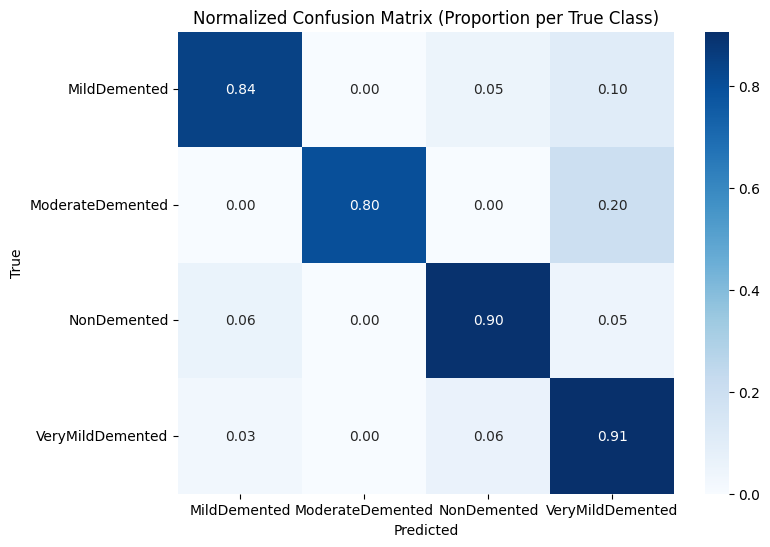

In [29]:
cm = confusion_matrix(labels, preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=[label_names[i] for i in range(len(label_names))],
            yticklabels=[label_names[i] for i in range(len(label_names))], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Proportion per True Class)')
plt.show()

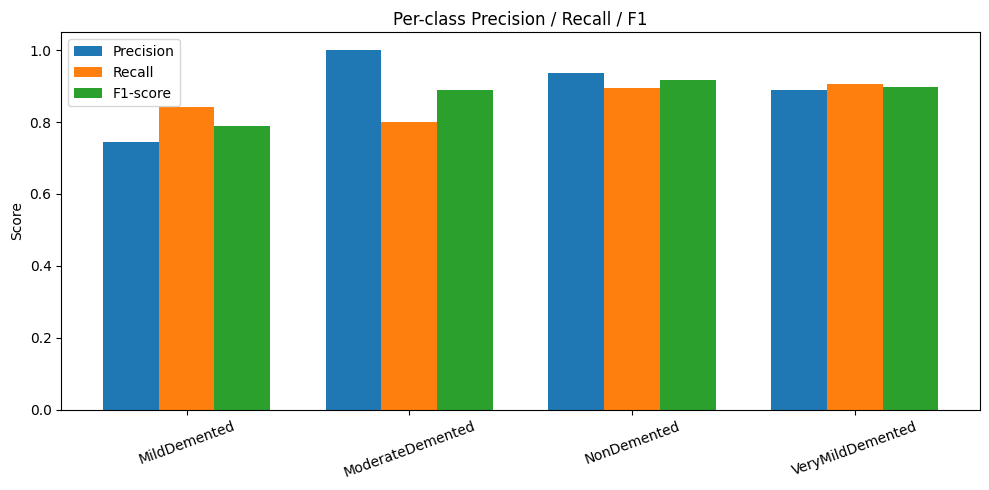

In [30]:
prec, rec, f1, sup = precision_recall_fscore_support(labels, preds, labels=list(range(len(label_names))))
classes = [label_names[i] for i in range(len(label_names))]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, classes, rotation=20)
plt.ylim(0,1.05)
plt.ylabel('Score')
plt.title('Per-class Precision / Recall / F1')
plt.legend()
plt.tight_layout()
plt.show()

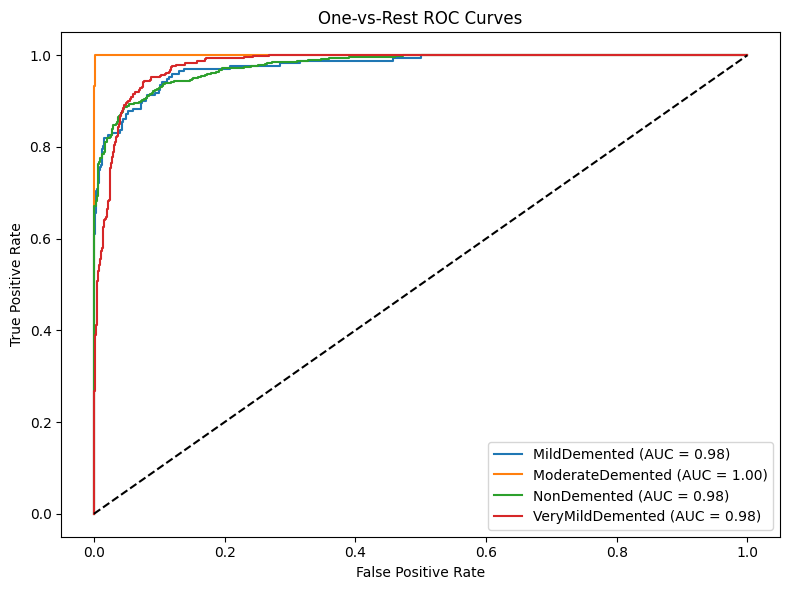

In [32]:
model.eval()
probs_all = []
labels_all = []
with torch.no_grad():
    for inputs, labs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        probs_all.append(probs)
        labels_all.extend(labs.numpy().tolist())
probs_all = np.vstack(probs_all)
y_true = np.array(labels_all)
n_classes = len(label_names)
y_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_names[i]} (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


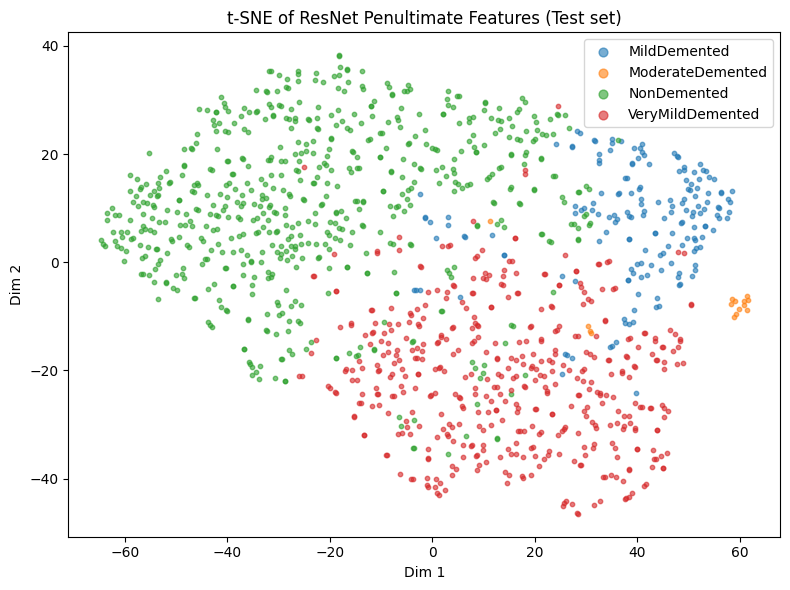

In [33]:
model.eval()
features = []
labels_feats = []
with torch.no_grad():
    for inputs, labs in test_loader:
        inputs = inputs.to(device)
        x = model.conv1(inputs)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.avgpool(x)
        x = torch.flatten(x, 1)
        features.append(x.cpu().numpy())
        labels_feats.extend(labs.numpy().tolist())

features = np.vstack(features)
labels_feats = np.array(labels_feats)

sample_n = 2000
if features.shape[0] > sample_n:
    idx = np.random.choice(features.shape[0], sample_n, replace=False)
    feat_sample = features[idx]
    lab_sample = labels_feats[idx]
else:
    feat_sample = features
    lab_sample = labels_feats

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
emb = tsne.fit_transform(feat_sample)

plt.figure(figsize=(8,6))
for i, cname in enumerate([label_names[i] for i in range(n_classes)]):
    mask = lab_sample == i
    plt.scatter(emb[mask,0], emb[mask,1], label=cname, alpha=0.6, s=10)
plt.legend(markerscale=2)
plt.title('t-SNE of ResNet Penultimate Features (Test set)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.tight_layout()
plt.show()

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None

        def save_grad(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        def save_activation(module, input, output):
            self.activations = output.detach()


        target_layer.register_forward_hook(save_activation)
        target_layer.register_full_backward_hook(save_grad)

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[0, class_idx]
        loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0,2,3])
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
        heatmap = torch.sum(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= (heatmap.max() + 1e-8)
        return heatmap, class_idx

target_layer = model.layer4
gcam = GradCAM(model, target_layer)

print("Grad-CAM object created")

Grad-CAM object created


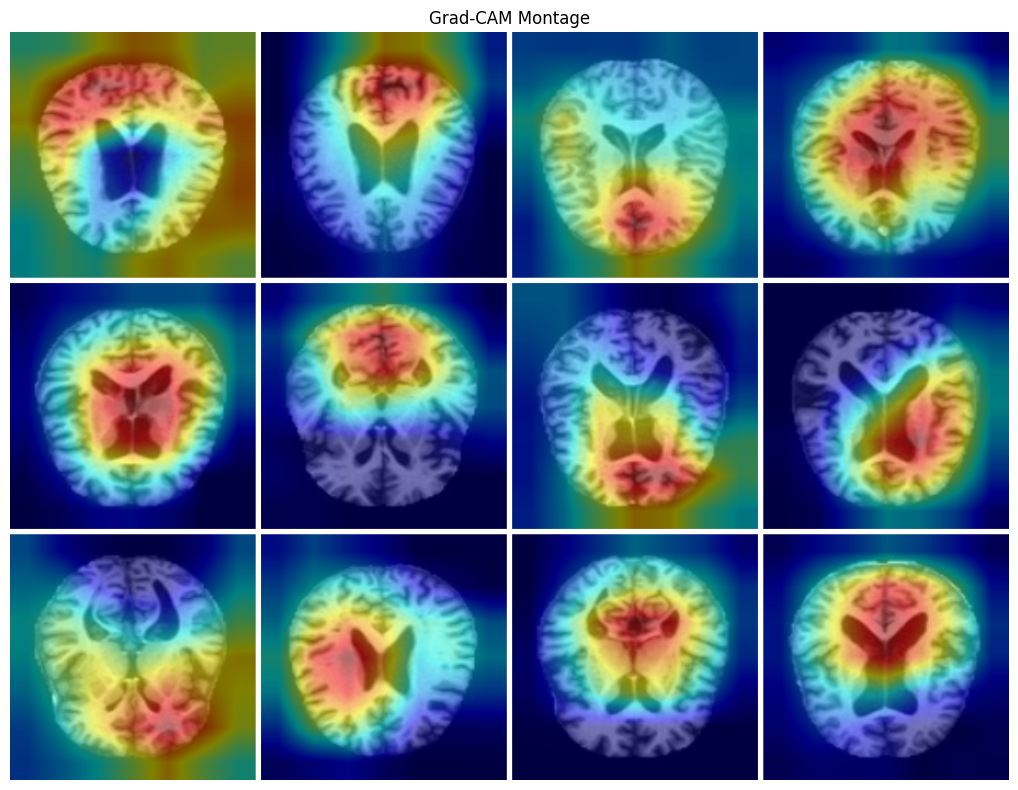

Saved: gradcam_montage/gradcam_montage.png


In [39]:
def generate_gradcam_overlay(inp_tensor, gcam):
    heatmap, pred_class = gcam(inp_tensor.to(device), None)
    inv_norm = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_norm(inp_tensor[0].cpu()).clamp(0,1)
    img_np = np.uint8(255 * img.permute(1,2,0).numpy())
    hmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    hmap_uint = np.uint8(255 * hmap)
    hmap_color = cv2.applyColorMap(hmap_uint, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(hmap_color, 0.5, img_np[..., ::-1], 0.5, 0)
    overlay = overlay[..., ::-1]
    return overlay, pred_class

import os
os.makedirs("gradcam_montage", exist_ok=True)

imgs_collected = []
titles = []
N = 12
count = 0
for inputs, labs in test_loader:
    for i in range(inputs.size(0)):
        inp = inputs[i].unsqueeze(0)
        overlay, pred = generate_gradcam_overlay(inp, gcam)
        imgs_collected.append(overlay)
        titles.append(f"T:{label_names[labs[i].item()]}|P:{label_names[pred]}")
        count += 1
        if count >= N:
            break
    if count >= N:
        break

rows, cols = 3, 4
h, w, _ = imgs_collected[0].shape
montage = np.ones((rows*h + (rows-1)*5, cols*w + (cols-1)*5, 3), dtype=np.uint8)*255
k = 0
for r in range(rows):
    for c in range(cols):
        if k >= len(imgs_collected): break
        r0, c0 = r*(h+5), c*(w+5)
        montage[r0:r0+h, c0:c0+w] = imgs_collected[k]
        k += 1

plt.figure(figsize=(12,8))
plt.imshow(montage)
plt.axis('off')
plt.title('Grad-CAM Montage')
plt.tight_layout()
plt.savefig("gradcam_montage/gradcam_montage.png", bbox_inches='tight')
plt.show()
print("Saved: gradcam_montage/gradcam_montage.png")